# Fashion-MNIST with a Fisher LDA Head
This notebook trains a small convolutional encoder with a Fisher-criterion LDA head on Fashion-MNIST, then visualises the learned embedding space.


### Setup


In [1]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from src.lda import FisherLDAHead


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device =', device)

device = cuda


### Data


In [3]:
tfm = transforms.ToTensor()
train_ds = datasets.FashionMNIST(root='./data', train=True, transform=tfm, download=True)
test_ds  = datasets.FashionMNIST(root='./data', train=False, transform=tfm, download=True)
train_ld = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=2, pin_memory=True)
test_ld  = DataLoader(test_ds,  batch_size=1024, shuffle=False, num_workers=2, pin_memory=True)
len(train_ds), len(test_ds)

(60000, 10000)

### Model: encoder + Fisher LDA head (fixed means, Fisher loss)


In [4]:
class Encoder(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
        )
        self.proj = nn.Linear(256, dim)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.proj(x)

class DeepFisherLDA(nn.Module):
    def __init__(self, C, D):
        super().__init__()
        self.encoder = Encoder(D)
        self.head = FisherLDAHead(C, D)

    def logits(self, x):
        z = self.encoder(x)
        return self.head.logits(z)

    def forward(self, x, y=None):
        z = self.encoder(x)
        if y is None:
            return self.head.logits(z)
        return self.head(z, y)


### Train & Eval


In [5]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    ok = tot = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model.logits(x)
        ok += (logits.argmax(1) == y).sum().item()
        tot += y.size(0)
    return ok / tot

model = DeepFisherLDA(C=10, D=9).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(1, 101):
    model.train()
    loss_sum = acc_sum = n_sum = 0
    for x, y in train_ld:
        x, y = x.to(device), y.to(device)
        loss = model(x, y)  # negative Fisher ratio
        opt.zero_grad(set_to_none=True); loss.backward(); opt.step()
        with torch.no_grad():
            logits = model.logits(x)
            pred = logits.argmax(1)
            acc_sum += (pred == y).sum().item()
            n_sum += y.size(0)
            loss_sum += loss.item() * y.size(0)
    tr_acc = acc_sum / n_sum
    te_acc = evaluate(model, test_ld)
    print(f"[{epoch:02d}] fisher_loss={loss_sum/n_sum:.4f} acc={tr_acc:.4f} | test acc={te_acc:.4f}")


[01] fisher_loss=-4.0485 acc=0.8736 | test acc=0.8832
[02] fisher_loss=-5.7798 acc=0.9255 | test acc=0.9074
[03] fisher_loss=-6.7789 acc=0.9362 | test acc=0.9190
[04] fisher_loss=-7.5761 acc=0.9454 | test acc=0.9213
[05] fisher_loss=-8.4288 acc=0.9531 | test acc=0.9175
[06] fisher_loss=-9.2303 acc=0.9576 | test acc=0.9255
[07] fisher_loss=-10.1282 acc=0.9635 | test acc=0.9150
[08] fisher_loss=-11.0206 acc=0.9682 | test acc=0.9178
[09] fisher_loss=-12.1670 acc=0.9732 | test acc=0.9285
[10] fisher_loss=-13.4231 acc=0.9781 | test acc=0.9323
[11] fisher_loss=-14.9820 acc=0.9823 | test acc=0.9255
[12] fisher_loss=-16.7486 acc=0.9857 | test acc=0.9359
[13] fisher_loss=-18.7325 acc=0.9888 | test acc=0.9272
[14] fisher_loss=-20.9072 acc=0.9912 | test acc=0.9103
[15] fisher_loss=-23.3266 acc=0.9926 | test acc=0.9345
[16] fisher_loss=-26.2641 acc=0.9948 | test acc=0.9389
[17] fisher_loss=-29.9428 acc=0.9960 | test acc=0.9344
[18] fisher_loss=-34.0759 acc=0.9967 | test acc=0.9326
[19] fisher_loss

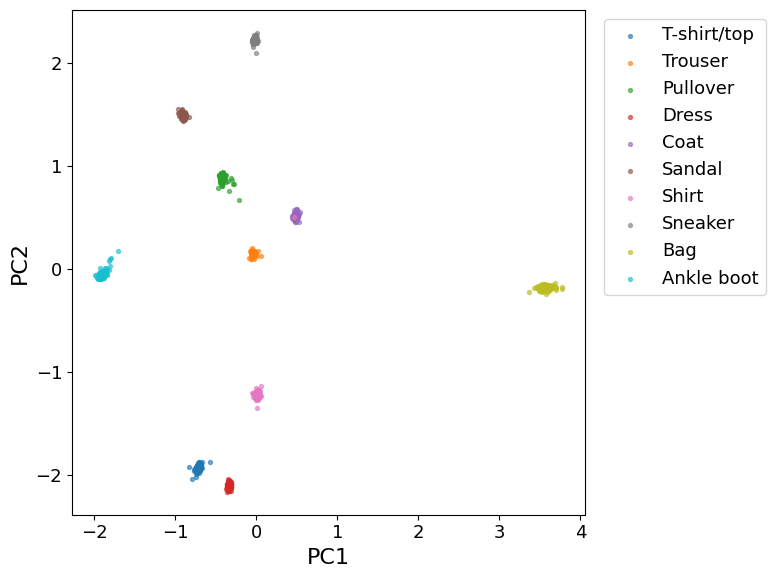

In [6]:
import matplotlib.pyplot as plt

model.eval()
embeds, labels = [], []
with torch.no_grad():
    for i, (x, y) in enumerate(train_ld):   # use train_ld if you prefer
        x = x.to(device)
        z = model.encoder(x).cpu()
        embeds.append(z)
        labels.append(y)
        if i >= 9:   # 10 batches ≈10k points; raise/lower to taste
            break

z = torch.cat(embeds)
y = torch.cat(labels)

# 2D projection (PCA)
z0 = z - z.mean(0, keepdim=True)
U, S, V = torch.pca_lowrank(z0, q=2)
z2 = z0 @ V[:, :2]

plt.rcParams.update({
    "font.size": 14, "axes.labelsize": 16, "legend.fontsize": 13,
    "xtick.labelsize": 13, "ytick.labelsize": 13
})

plt.figure(figsize=(8, 6))
for c in range(10):
    idx = y == c
    plt.scatter(z2[idx, 0], z2[idx, 1], s=8, alpha=0.6, label=train_ds.classes[c])
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
plt.savefig('plots/fashion_mnist_fisher_embeddings.png', dpi=600)
